# Example 4.3 - Inference of dozens of parameters of a neuroscience model

In this example, we illustrate an example of SBI applied to an inference problem with
a large (31) number of parameters. This examples also shows the use of ensemble
posteriors, and highlights the evaluation workflow for simulation-based inference.

In [1]:
import numpy as np
import os

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from sbi.inference import NPE, DirectPosterior
from sbi.inference.posteriors import EnsemblePosterior
from copy import deepcopy
import pickle
import torch
import pandas as pd
from paper.colors import colors
import seaborn as sns


# To run this notebook, you need the pyloric environment (see README for instructions).
from pyloric import simulate, create_prior, summary_stats
from pyloric.utils import show_traces
from sbi.utils.user_input_checks_utils import PytorchReturnTypeWrapper





### Load data

In this example, we use 3 million simulations. We provide the simulations and load 
the summary statistics here.

In [2]:
with open("data/training_simulations/all_circuit_parameters.pkl", "rb") as handle:
    theta = pickle.load(handle)
with open("data/training_simulations/all_simulation_outputs.pkl", "rb") as handle:
    x = pickle.load(handle)
seeds = np.load("data/training_simulations/all_seeds.npy")
x_o = np.load(
    "data/xo_11deg.npy",
    allow_pickle=True,
)

/var/folders/4q/8fx0bbzx37x2pnkf3h36dsgm0000gn/T/ipykernel_50298/2905989494.py:2: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  theta = pickle.load(handle)
/var/folders/4q/8fx0bbzx37x2pnkf3h36dsgm0000gn/T/ipykernel_50298/2905989494.py:4: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world us

### Clean Data

When simulating from the prior distribution, the pyloric network simulator produces 
summary statistics that are ill-defined. We clean the data here by capping the summary
statistics to reasonable ranges, and replace undefined summary statistics with
unreasonable values.

In [3]:
def clean_data(x):
    clean_x = []
    for i in range(18):
        x_ = x.to_numpy()[:, i]
        nan_vals = np.isnan(x_)
        if i == 0:
            x_[x_ > 3000] = 3000
            x_[nan_vals] = 3000

        if i in [1, 2, 3]:
            x_[x_ > 500] = 500
            x_[nan_vals] = 500

        if i in [4, 5, 6]:
            x_[x_ > 1] = 1
            x_[nan_vals] = 1

        if i in [7, 8]:
            x_[nan_vals] = 1.0

        if i in [9, 10, 11, 12]:
            x_[x_ < -1000] = -1000
        if i in [9, 10, 11, 12]:
            x_[x_ > 1000] = 1000
            x_[nan_vals] = 1000

        if i in [13, 14]:
            x_[x_ > 1] = 1
            x_[nan_vals] = 1
        if i in [13, 14]:
            x_[x_ < -1] = -1

        if i in [15, 16, 17]:
            x_[x_ > 10] = 10
            x_[nan_vals] = 100            
        clean_x.append(x_)
    return torch.as_tensor(np.asarray(clean_x).T, dtype=torch.float32)

clean_x = clean_data(x)
clean_theta = torch.as_tensor(theta.to_numpy(), dtype=torch.float32)

### Train NPE model

Training is performed just as in the ball throw example. However, due to the large
number of training simulations and parameters, this is restrictively slow. Here, we 
provide trained NPE models, and load them.

In [4]:
### Training code - very slow due to the number of parameters and simulations.


# prior = create_prior(as_torch_dist=True)
# prior = PytorchReturnTypeWrapper(prior)
# inference = NPE(prior, "nsf")
# inference = inference.append_simulations(clean_theta, clean_x).train()

### Ensemble Posteriors

We train 5 identical NPE models with different random seeds. The ensemble posterior
is then just an equally weighted mix of these 5 individual posteriors. Training
ensemble posteriors can improve the calibration of the posterior, by reducing the bias
arising from imperfect training.

In [5]:
posteriors = []
for i in range(5):
    with open(f"results/trained_neural_nets/density_estimator_seed{i}.pkl", "rb") as handle:
        density_estimator = pickle.load(handle)
    prior = create_prior(as_torch_dist=True)
    posterior = DirectPosterior(density_estimator, prior)
    posteriors.append(posterior)
posterior = EnsemblePosterior(posteriors)

### Visualizing The Posterior

We can plot the pairplot for the 31-dimensional pairplot here, but this may be hard to
interpret due to the large number of parameters. Here, we plot the marginal
distributions of a subset of the parameters, scaled by the prior ranges, to investigate
how constrained the posterior is relative to the prior.

/Users/guymoss/miniconda3/envs/tutorial-paper/lib/python3.11/site-packages/nflows/transforms/lu.py:80: UserWarning: torch.triangular_solve is deprecated in favor of torch.linalg.solve_triangularand will be removed in a future PyTorch release.
torch.linalg.solve_triangular has its arguments reversed and does not return a copy of one of the inputs.
X = torch.triangular_solve(B, A).solution
should be replaced with
X = torch.linalg.solve_triangular(A, B). (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/BatchLinearAlgebra.cpp:2196.)
  outputs, _ = torch.triangular_solve(


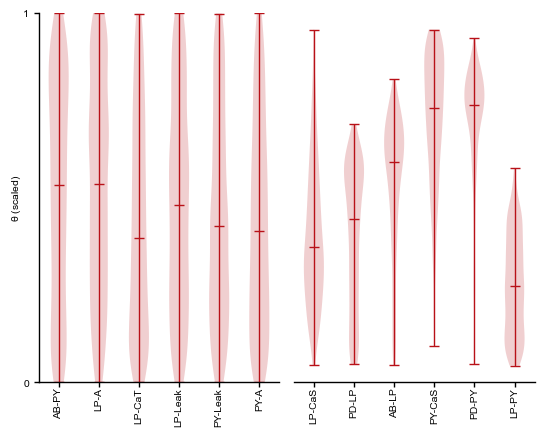

In [6]:
# Sample posterior

_ = torch.manual_seed(0)
num_samples = 1_000
posterior_samples = posterior.sample((num_samples,), x=x_o,show_progress_bars=False)

# Prior limits
limits = torch.stack([
    prior.support.base_constraint.lower_bound,
    prior.support.base_constraint.upper_bound,
]).T


posterior_samples -= limits[:, 0]
posterior_samples /= (limits[:, 1] - limits[:, 0])

stds = torch.std(posterior_samples, axis=0)
sorting = torch.argsort(stds, descending=True)

p1 = create_prior()
pars = p1.sample((1,))
column_names = pars.columns
joined = column_names.map(lambda x: f"{'' if x[0] == 'Synapses' else x[0] + '-'}{x[1]}").tolist()


with mpl.rc_context(fname="../../.matplotlibrc"):
    n = 6
    fig, ax = plt.subplots(1, 2)
    parts = ax[0].violinplot(
        posterior_samples[:1_000, sorting[:n]].numpy(),
        showmeans=False,
        showmedians=True,
    )
    for pc in parts["bodies"]:
        pc.set_facecolor(colors["theta_shades"][3])  # or any color you like
        pc.set_alpha(0.2)  # optional transparency
        
    # Style median line
    if "cmedians" in parts:
        parts["cmedians"].set_color(colors["theta_shades"][3])

    # Style vertical bars (min to max)
    if "cbars" in parts:
        parts["cbars"].set_color(colors["theta_shades"][3])

    # Style caps (min and max horizontal lines)
    if "cmins" in parts:
        parts["cmins"].set_color(colors["theta_shades"][3])
    if "cmaxes" in parts:
        parts["cmaxes"].set_color(colors["theta_shades"][3])

    ax[0].set_xticks(np.arange(1, n+1))
    ax[0].set_xticklabels([joined[s] for s in sorting[:n]], rotation=90)
    ax[0].set_xlim(0.5, n+0.5)
    ax[0].set_ylim([0, 1])
    ax[0].set_yticks([0, 1])
    ax[0].set_ylabel(r"$\theta$"+" (scaled)", labelpad=0)
    
    parts = ax[1].violinplot(
        posterior_samples[:1_000, sorting[-n:]].numpy(),
        showmeans=False,
        showmedians=True
    )
    for pc in parts["bodies"]:
        pc.set_facecolor(colors["theta_shades"][3])  # or any color you like
        pc.set_alpha(0.2)  # optional transparency
        
    # Style median line
    if "cmedians" in parts:
        parts["cmedians"].set_color(colors["theta_shades"][3])

    # Style vertical bars (min to max)
    if "cbars" in parts:
        parts["cbars"].set_color(colors["theta_shades"][3])

    # Style caps (min and max horizontal lines)
    if "cmins" in parts:
        parts["cmins"].set_color(colors["theta_shades"][3])
    if "cmaxes" in parts:
        parts["cmaxes"].set_color(colors["theta_shades"][3])
    ax[1].spines["left"].set_visible(False)
    ax[1].set_yticks([])
    ax[1].set_xticks(np.arange(1, n+1))
    ax[1].set_xticklabels([joined[s] for s in sorting[-n:]], rotation=90)
    ax[1].set_xlim(0.5, n+0.5)
    ax[0].tick_params(axis="x", pad=0)
    ax[1].tick_params(axis="x", pad=0)

    plt.subplots_adjust(wspace=0.06)
    plt.show()

### Conditional marginal distributions

The marginal posteriors we plotted above are still broad. However, by plotting marginal
distributions conditioned on the values of the rest of the parameters, we can see that
the posterior distribution is strongly constrained in terms of the trade-off effects
between different parameters. In other words, the posterior learned the degeneracies of 
the forward model.

/Users/guymoss/miniconda3/envs/tutorial-paper/lib/python3.11/site-packages/torch/functional.py:534: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3596.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


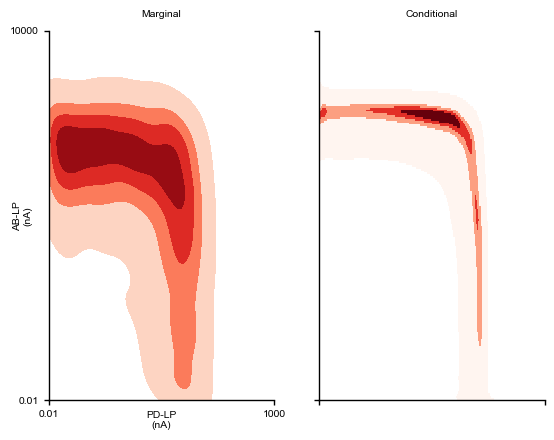

In [7]:
_ = torch.manual_seed(0)
num_samples = 10_000

#To plot the marginal distribution, we just generate samples from the posterior, and
#discard the dimensions we are not plotting.
posterior_samples = posterior.sample((num_samples,), x=x_o,show_progress_bars=False)



#To plot the conditional distribution, we show the heatmap of the probabilities
#of the conditional distribution. To do this, we generate one sample from the
#posterior, and calculate the probability of this sample as we change the values across
#the two marginal axes.

posterior = posterior.set_default_x(x_o)
_ = torch.manual_seed(1) # 1
res = 200
x = torch.linspace(-18.4, -4.6, res) # PD-LP prior range
y = torch.linspace(-18.4, -6.9, res) # AB-LP prior range
X, Y = torch.meshgrid(x, y)
xy = torch.stack([X, Y])
xy = torch.reshape(xy, (2, res**2)).T

sample = posterior.sample((1,), x=x_o,show_progress_bars=False)
sample = sample.repeat((res**2, 1))
sample[:, 24] = xy[:, 0]
sample[:, 25] = xy[:, 1]

probs = posterior.log_prob(sample).exp()
probs = torch.reshape(probs, (res, res))

with mpl.rc_context(fname="../../.matplotlibrc"):
    fig, ax = plt.subplots(1,2)
    sns.kdeplot(
        x=posterior_samples[:10_000, 25],
        y=posterior_samples[:10_000, 24],
        fill=True,
        thresh=0.05,
        levels=5,
        cmap="Reds",
        ax=ax[0],
    )
    _ = ax[0].set_xticks([-18.4, -6.9])
    _ = ax[0].set_xlim([-18.4, -6.9])
    _ = ax[0].set_xticklabels([0.01, 1_000])
    _ = ax[0].set_yticks([-18.4, -4.6])
    _ = ax[0].set_ylim([-18.4, -4.6])
    _ = ax[0].set_yticklabels([0.01, 10_000])
    _ = ax[0].set_xlabel("PD-LP\n(nA)", labelpad=-6)
    _ = ax[0].set_ylabel("AB-LP\n(nA)", labelpad=-16)
    _ = ax[0].set_title("Marginal", pad=10)
    
    
    
    
    threshold = 0.001 * np.max(probs.numpy())
    levels = np.linspace(0.001 * np.max(probs.numpy()), np.max(probs.numpy()), 5)
    
    extent = [-18.4, -6.9, -18.4, -4.6]

    # Create a colormap and normalize it
    cmap = plt.get_cmap("Reds", len(levels) - 1)
    cmap.set_under(color=(1, 1, 1, 0))  # fully transparent for values below threshold

    norm = mcolors.BoundaryNorm(boundaries=levels, ncolors=cmap.N)

    # Plot
    ax[1].imshow(
        probs.numpy(),
        extent=extent,
        origin='lower',
        aspect='auto',
        interpolation='none',
        cmap=cmap,
        norm=norm,
    )
    _ = ax[1].set_xticks([-18.4, -6.9])
    _ = ax[1].set_xlim([-18.4, -6.9])
    _ = ax[1].set_xticklabels([])
    _ = ax[1].set_yticks([-18.4, -4.6])
    _ = ax[1].set_ylim([-18.4, -4.6])
    _ = ax[1].set_yticklabels([])
    _ = ax[1].set_title("Conditional", pad=10)

    plt.show()

# Posterior Predictive Samples

As in the ball throw example, we can simulate samples from the posterior to visualize
the posterior predictive distribution. Here we plot one posterior predictive sample.

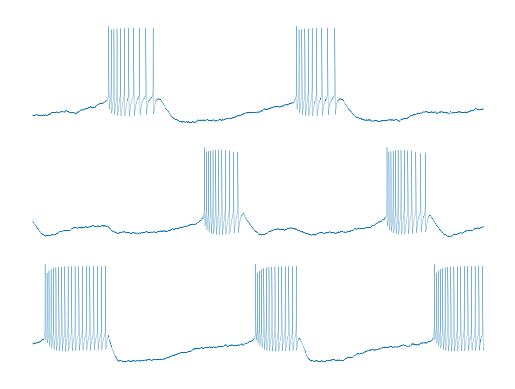

In [8]:
_ = torch.manual_seed(0)
num_samples = 1
posterior_samples = posterior.sample((num_samples,), x=x_o,show_progress_bars=False)

p1 = create_prior()
pars = p1.sample((1,))
column_names = pars.columns
parameter_set_pd = pd.DataFrame(np.asarray(posterior_samples), columns=column_names)

all_stats = []
for i in range(num_samples):
    simulation_output = simulate(parameter_set_pd.loc[i], seed=1)




offset = 72_000
t = 2.5  # seconds
with mpl.rc_context(fname="../../.matplotlibrc"):
    fig, ax = plt.subplots(1, 1)
    for i in range(3):
        ax.plot(simulation_output["voltage"][i, offset:offset+int(t * 40 * 1000)] - 150.0 * i, color=colors["x"], linewidth=0.2)
    ax.spines["left"].set_visible(False)
    ax.spines["bottom"].set_visible(False)
    ax.set_xticks([])
    ax.set_yticks([])
    plt.show()

### Global Posterior Validation

By simulating many synthetic observations from the prior, we can perform global
validation checks, namely psoterior coverage and simulation-based calibration on the
posterior marginals. We can also compare the calibration of our ensemble posterior to 
the calibration of the individual posteriors.

The simulations and calibration checks can take some time (~10 minutes), so here we
provide also the saved ranks for plotting.

In [9]:
# # Create validation set

# _ = torch.manual_seed(0)

# num_sbc_samples = 300  # choose a number of sbc runs, should be ~100s
# prior_samples = prior.sample((num_sbc_samples,))

# p1 = create_prior()
# pars = p1.sample((1,))
# column_names = pars.columns
# parameter_set_pd = pd.DataFrame(np.asarray(prior_samples), columns=column_names)

# all_stats = []
# for i in range(num_sbc_samples):
#     if i % 50 == 0:
#         print("i", i)
#     simulation_output = simulate(parameter_set_pd.loc[i])
#     summary_statistics = summary_stats(simulation_output, stats_customization={"plateau_durations": True})
#     all_stats.append(summary_statistics)
# summary_statistics = pd.concat(all_stats)
# prior_predictives = clean_data(summary_statistics.copy())

### Global Validation of Posterior

We can compute the posterior coverage and simulation-based calibration checks of the 
ensemble posterior, as well as the coverage of the individual posteriors in the
ensemble.

### Posterior Coverage

For each $\theta,x$ in our validation set, we can compute the posterior log-probability
of the true $\theta$ compared to samples from the posterior conditioned on $x$. The 
ranks of the log-probabilities of the true $\theta$s should be uniformly distributed.

In [10]:
# run SBC: for each inference we draw 1000 posterior samples.
# from sbi.diagnostics import run_sbc
# num_posterior_samples = 1_000
# ranks, dap_samples = run_sbc(
#     prior_samples,
#     prior_predictives,
#     posterior,
#     reduce_fns=lambda theta, x: -posterior.log_prob(theta, x),
#     num_posterior_samples=num_posterior_samples,
#     use_batched_sampling=False,  # `True` can give speed-ups, but can cause memory issues.
# )

with open("results/diagnostic_results/ensemble_exp_cov_ranks.pkl", "rb") as handle:
    ranks = pickle.load(handle)
with open("results/diagnostic_results/ensemble_exp_cov_dap_samples.pkl", "rb") as handle:
    dap_samples = pickle.load(handle)


#We can also repeat this for the individual posteriors in the ensemble - here we load
#the saved results

individual_ranks = []
for individual in range(5):
    with open(f"results/diagnostic_results/individual_{individual}_exp_cov_ranks.pkl", "rb") as handle:
        new_ranks = pickle.load(handle)
    individual_ranks.append(new_ranks)
individual_ranks = torch.cat(individual_ranks, axis=1)
ranks = torch.cat([ranks, individual_ranks], axis=1)



We generate the plot of the ranks below

We see that the ensemble posterior has ranks that are closer to uniform than any of the
individual posteriors, indicating that it is well-calibrated.

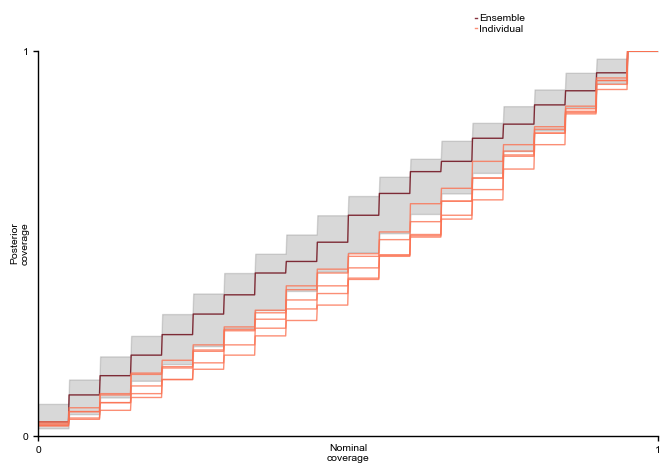

In [11]:
from sbi.analysis.plot import _sbc_rank_plot

num_posterior_samples = 1_000

with mpl.rc_context(fname="../../.matplotlibrc"):
    individual_col = colors["theta_shades"][1]
    fig, ax = _sbc_rank_plot(
        ranks,
        num_posterior_samples,
        plot_type="cdf",
        num_bins=20,
        colors=[colors["theta_shades"][4], individual_col, individual_col, individual_col, individual_col, individual_col],
    )
    ax.set_xticks([0, 20])
    ax.set_yticks([0, 1])
    ax.set_yticklabels([0, 1])
    ax.set_xticklabels([0, 1])
#     ax.set_xlabel("Posterior rank", labelpad=-3)
#     ax.set_ylabel("Empirical CDF", labelpad=-1)
    _ = ax.set_xlabel("Nominal\ncoverage", labelpad=-8)
    _ = ax.set_ylabel("Posterior\ncoverage", labelpad=-5)
    _ = ax.legend(
        ["Ensemble", "Individual"],
        loc="upper right",
        bbox_to_anchor=[0.8, 1.12, 0.0, 0.0],
        handlelength=0.2,
        handletextpad=0.2,
        labelspacing=0.1,
    )
    plt.show()

### SBC

For each $\theta,x$ in our validation set, we can also calculate the rank of the true 
$\theta$ compared to posterior samples by ordering the values in the individual
dimensions of the parameter space (the one-dimensional marginal distributions). Again,
the ranks should be uniform.

In [12]:
# run SBC: for each inference we draw 1000 posterior samples.
# from sbi.diagnostics import run_sbc
# num_posterior_samples = 1_000
# ranks, dap_samples = run_sbc(
#     prior_samples,
#     prior_predictives,
#     posterior,
#     num_posterior_samples=num_posterior_samples,
#     use_batched_sampling=False,  # `True` can give speed-ups, but can cause memory issues.
# )

with open("results/diagnostic_results/ensemble_sbc_ranks.pkl", "rb") as handle:
    ranks = pickle.load(handle)
with open("results/diagnostic_results/ensemble_sbc_dap_samples.pkl", "rb") as handle:
    dap_samples = pickle.load(handle)


For clarity, we show only the first three dimensions of the marginal, and we also
don't compare to the calibration of the individual posteriors, however, we could
in principle show this analysis for all dimensions of the parameter space, and for all
individual posteriors in the ensemble.

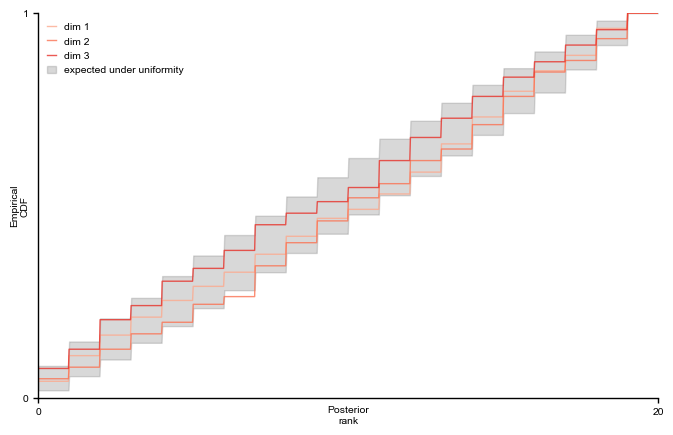

In [13]:
dims = 3
with mpl.rc_context(fname="../../.matplotlibrc"):
    fig, ax = _sbc_rank_plot(
        ranks[:, :dims],
        num_posterior_samples,
        num_bins=20,
        colors=[colors["theta_shades"][i] for i in range(dims)],
    )
    ax.set_xticks([0, 20])
    ax.set_yticks([0, 1])
    ax.set_yticklabels([0, 1])
    ax.set_xlabel("Posterior\nrank", labelpad=-8)
    ax.set_ylabel("Empirical\nCDF", labelpad=-5)
    plt.show()

### Local Calibration Checks with L-C2ST

To perform local calibration check with L-C2ST, we need to train a classifier to 
distinguish between samples from the true joint distribution $p(\theta,x)$, and samples
from the approximate joint $p(x)q_\phi(\theta|x)$, where $q_\phi$ is our posterior and
$x\sim p(x)$ is sampled by simulating samples from the prior distribution.

If we have estimated the true posterior perfectly for a given value of $x$, then the 
classifier will not be able to distinguish between samples at that posterior and samples
from the true joint.

To run L-C2ST, we again need to create a dataset of simulations distinct from the
training dataset used to learn the posterior, and then train a classifier. Here, we 
provide an already trained classifier and load it.

In [14]:
# p1 = create_prior()
# pars = p1.sample((1,))
# column_names = pars.columns

# for seed in range(1015, 1020):
#     _ = torch.manual_seed(seed)

#     num_lc2st_samples = 1_000  # choose a number of sbc runs, should be ~100s
#     prior_samples = prior.sample((num_lc2st_samples,))
#     parameter_set_pd = pd.DataFrame(np.asarray(prior_samples), columns=column_names)

#     all_stats = []
#     for i in range(num_lc2st_samples):
#         if i % 100 == 0:
#             print("i", i)
#         simulation_output = simulate(parameter_set_pd.loc[i])
#         summary_statistics = summary_stats(simulation_output, stats_customization={"plateau_durations": True})
#         all_stats.append(summary_statistics)
#     summary_statistics = pd.concat(all_stats)
#     prior_predictives = clean_data(summary_statistics.copy())



In [15]:
# from sbi.diagnostics.lc2st import LC2ST
# from sbi.utils.torchutils import atleast_2d

# # Generate one posterior sample for every prior predictive.
# post_samples_cal = posterior.sample_batched(
#     (1,),
#     x=prior_predictives,
#     max_sampling_batch_size=10
# )[0]

# # Train the L-C2ST classifier.
# lc2st = LC2ST(
#     thetas=prior_samples,
#     xs=prior_predictives,
#     posterior_samples=post_samples_cal,
#     classifier="mlp",
#     num_ensemble=1,
# )
# _ = lc2st.train_under_null_hypothesis()
# _ = lc2st.train_on_observed_data()


with open("results/diagnostic_results/lc2st_net.pkl", "rb") as handle:
    lc2st = pickle.load(handle)

/Users/guymoss/miniconda3/envs/tutorial-paper/lib/python3.11/site-packages/sklearn/base.py:440: InconsistentVersionWarning: Trying to unpickle estimator LabelBinarizer from version 1.6.1 when using version 1.7.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/guymoss/miniconda3/envs/tutorial-paper/lib/python3.11/site-packages/sklearn/base.py:440: InconsistentVersionWarning: Trying to unpickle estimator MLPClassifier from version 1.6.1 when using version 1.7.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [16]:
_ = torch.manual_seed(0)

# Note: x_o must have a batch-dimension. I.e. `x_o.shape == (1, observation_shape)`.
post_samples_star = posterior.sample((10_000,), x=x_o,show_progress_bars=False)
probs_data, scores_data = lc2st.get_scores(
    theta_o=post_samples_star,
    x_o=torch.as_tensor(x_o),
    return_probs=True,
    trained_clfs=lc2st.trained_clfs
)
probs_null, scores_null = lc2st.get_statistics_under_null_hypothesis(
    theta_o=post_samples_star,
    x_o=torch.as_tensor(x_o),
    return_probs=True,
)

conf_alpha = 0.05
p_value = lc2st.p_value(post_samples_star, torch.as_tensor(x_o).unsqueeze(0))
reject = lc2st.reject_test(post_samples_star, torch.as_tensor(x_o).unsqueeze(0), alpha=conf_alpha)

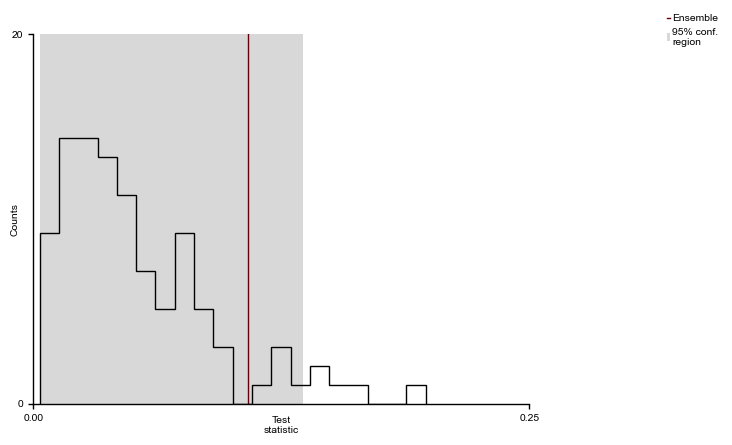

In [17]:
with mpl.rc_context(fname="../../.matplotlibrc"):
    fig, ax = plt.subplots(1, 1)
    quantiles = np.quantile(scores_null, [0, 1-conf_alpha])
    
    ax.axvline(scores_data, color=colors["theta_shades"][4], label="Observed")
    ax.fill_betweenx(np.linspace(0, 20, 20), quantiles[0] * np.ones(20), quantiles[1] * np.ones(20), color="gray", alpha=0.3, edgecolor=None)
    ax.hist(scores_null, bins=20, density=True, alpha=1.0, label="Null", facecolor="k", color="k", histtype="step")
    ax.set_xlabel("Test\nstatistic", labelpad=-5)
    ax.set_ylabel("Counts", labelpad=-5)
    ax.set_yticks([0, 20])
    ax.set_ylim([0, 20])
    ax.set_xticks([0, 0.25])
    ax.set_xlim([0, 0.25])
#     ax.set_title(f"p-value = {p_value:.2f}")
    ax.legend(
        ["Ensemble", "95% conf.\nregion"],
        loc="upper right",
        bbox_to_anchor=[1.4, 1.08, 0.0, 0.0],
        handlelength=0.3,
        handletextpad=0.2,
        labelspacing=0.4,
    )
    plt.show()